In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from natsort import natsorted
import glob

In [3]:
im1 = Image.open("output/image_0.png")
im1 = im1.resize((384, 384))
im1 = im1.convert("L")
im1 = np.array(im1)
im2 = Image.open("output/image_1.png")
im2 = np.array(im2)

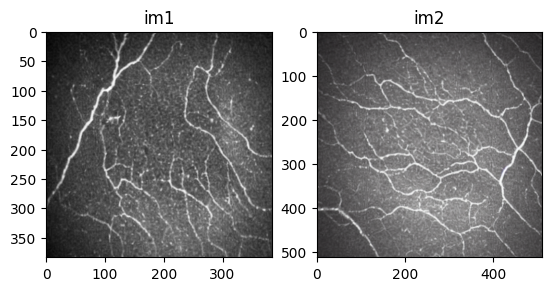

In [4]:
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.imshow(im1, cmap='gray')
plt.title('im1')

plt.subplot(1, 2, 2)
plt.imshow(im2)
plt.title('im2')

plt.show()

In [5]:
def calculateDistance(im1, im2):
    return np.sum((im1-im2)**2)

In [6]:
# Loop through all images in the training dataset (Nerves) and find the 10 images with lowest euclidean distance to the inferenced image
files = natsorted(glob.glob("Nerves/*.jpg"))
distances = []
for file in files:
    im = Image.open(f"{file}")
    im = im.convert("L")
    im = np.array(im)
    distances.append(calculateDistance(im1, im))

In [7]:
from numpy import sort

sort(distances)

array([13611929, 13812440, 13821322, ..., 17093040, 17113828, 17137889],
      dtype=uint64)

In [8]:
index = 0
for i in range(1, len(distances)):
    if distances[i] == 13611929:
        index = i
        break

In [9]:
index

626

In [10]:
import numpy as np

# Search for a value in the 'im' array
value_to_search = 13812440
indices = np.where(distances == value_to_search)

# Print the indices where the value is found
print(indices)

(array([], dtype=int64),)


/tmp/ipykernel_792853/1285888985.py:5: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  indices = np.where(distances == value_to_search)


In [11]:
test_im = Image.open("Nerves/626.jpg")
test_im = test_im.resize((384, 384))
test_im = test_im.convert("L")
test_im = np.array(test_im)

In [12]:
calculateDistance(im1, test_im)

13611929

In [21]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
from PIL import Image
import os

def load_and_flatten_image(filepath):
    img = Image.open(filepath).convert('L')  # Convert to grayscale for simplicity
    img = img.resize((256, 256))  # Resize to a consistent size
    return np.array(img).flatten()

# Load im1
im1_path = 'output/image_0.png'
im1_vector = load_and_flatten_image(im1_path)

# Load and flatten images from the nerves folder
nerves_folder = 'Nerves'
image_vectors = [load_and_flatten_image(os.path.join(nerves_folder, filename)) for filename in os.listdir(nerves_folder)]

# Add im1_vector to the list of vectors for NearestNeighbors fitting
image_vectors_with_im1 = np.array([im1_vector] + image_vectors)

# Use Nearest Neighbors to find similar images
nn = NearestNeighbors(n_neighbors=5, metric='euclidean').fit(image_vectors_with_im1)
distances, indices = nn.kneighbors([im1_vector])

# indices[0] contains the indices of the 5 nearest neighbors to im1
print("Indices of nearest images:", indices[0])

Indices of nearest images: [   0 1014  289 1230 1376]


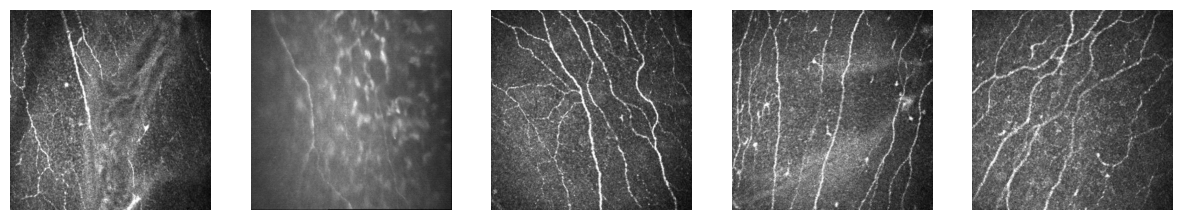

In [22]:
# Load and display the 5 nearest images
plt.figure(figsize=(15, 5))
for i, index in enumerate(indices[0]):
    plt.subplot(1, 5, i + 1)
    img = Image.open(os.path.join(nerves_folder, os.listdir(nerves_folder)[index]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()


In [23]:
import torch
if torch.cuda.is_available():
    print(str(torch.cuda.device_count()) + " GPUs are available")
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_properties(i).name)
else:
    print("GPU is not available")

2 GPUs are available
NVIDIA TITAN RTX
NVIDIA TITAN RTX


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

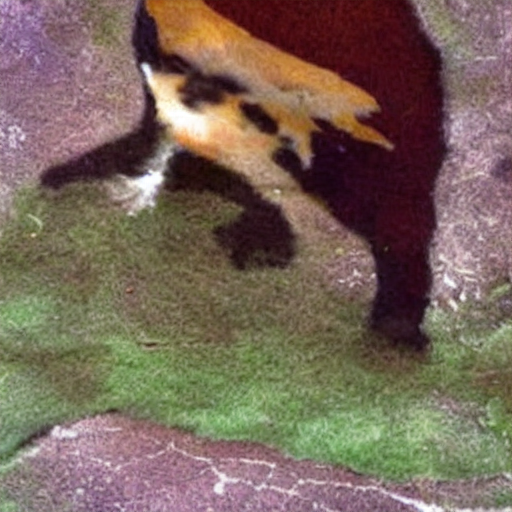

In [42]:
# Load the model and generate 100 images
import torch
from torchvision import transforms
from diffusers import AutoencoderKL, DDPMScheduler, DiffusionPipeline, StableDiffusionPipeline, UNet2DConditionModel

pipeline = DiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    revision=None,
    variant=None,
    torch_dtype=torch.bfloat16,
)
            

# load attention processors
pipeline.load_lora_weights("output/pytorch_lora_weights.safetensors")
pipeline.to(torch.device("cuda"))

# run inference
pipeline("dog", num_inference_steps=30).images[0]

In [41]:
from accelerate import PartialState

distributed_state = PartialState()
pipeline.to(distributed_state.device)

# Assume two processes
with distributed_state.split_between_processes(["medical image of nerves taken at Langevin Institute", "dog"]) as prompt:
    result = pipeline(prompt, num_inference_steps=10).images[0]
    result.save(f"result_{distributed_state.process_index}.png")

  0%|          | 0/10 [00:00<?, ?it/s]

In [55]:
from torch.utils.data import DataLoader
from torchvision.datasets import DatasetFolder
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchmetrics.image.fid import FrechetInceptionDistance
import torch
import glob
from natsort import natsorted
from PIL import Image

# Assuming you have your datasets in folders
nerves_dataset_path = 'Nerves'
inference_dataset_path = 'inference'

# Custom dataset to load images
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        image = Image.open(img_path).convert('RGB')
        image = ToTensor()(image)
        if self.transform:
            image = self.transform(image)
        return image

# Transformations
transforms = Compose([
    Resize((299, 299)),  # Resize images to fit Inception model
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalization for Inception
])

# Load datasets
nerves_dataset_files = natsorted(glob.glob("Nerves/*.jpg"))
inference_dataset_files = natsorted(glob.glob("inference/*.png"))

nerves_dataset = CustomImageDataset(nerves_dataset_files, transform=transforms)
inference_dataset = CustomImageDataset(inference_dataset_files, transform=transforms)

# Create DataLoaders
nerves_loader = DataLoader(nerves_dataset, batch_size=32, shuffle=False)
inference_loader = DataLoader(inference_dataset, batch_size=32, shuffle=False)

# Initialize FID metric
fid = FrechetInceptionDistance(feature=2048)

# Function to update FID with features from a dataset
def update_fid(loader, fid, real=True):
    for batch in loader:
        # Move batch to the same device as FID metric
        batch = batch.to(torch.uint8)
        batch = batch.to(fid.device)
        # Update FID with features from this batch
        fid.update(batch, real=real)

# Compute features from both datasets
update_fid(nerves_loader, fid, real=True)  # Update with real images
update_fid(inference_loader, fid, real=False)  # Update with generated/inference images

# Calculate FID score
fid_score = fid.compute()

print(f'FID Score: {fid_score}')

FID Score: 139.513671875


In [56]:
!python -m pytorch_fid Nerves inference

6017.80s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  3.18it/s]
FID:  126.67471690759155


In [64]:
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM

x = torch.Tensor()
y = torch.Tensor()

for batch in nerves_loader:
    x = torch.cat((x, batch), dim=0)

for batch in inference_loader:
    y = torch.cat((y, batch), dim=0)

ms_ssim_val = ms_ssim(x[:198, :, :, :], y, data_range=255, size_average=False )

In [69]:
torch.mean(ms_ssim_val)

tensor(0.9798)